In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
import torch
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists
from sqlalchemy.sql import text

from merlion.utils import TimeSeries
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from merlion.evaluate.forecast import ForecastMetric
from merlion.transform.normalize import MinMaxNormalize


from merlion.models.ensemble.combine import Mean, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig

import os

import random
random.seed(42)

In [2]:
#прочитаем csv в Pandas
df = pd.read_csv("burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter.csv")
#преобразуем текст в дату
df["Date"] = pd.to_datetime(df["Date"])
#установим индекс по времени, т.к. это требование метода UnivariateTimeSeries.from_pd()
df = df.set_index("Date")
df

,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
Date,,,,,
2014-01-01 00:00:00,15.0,0.0,2.0,2.0,11.0
2014-01-01 01:00:00,9.0,1.0,0.0,1.0,7.0
2014-01-01 02:00:00,9.0,0.0,0.0,0.0,9.0
2014-01-01 03:00:00,19.0,0.0,0.0,0.0,19.0
2014-01-01 04:00:00,19.0,0.0,0.0,0.0,19.0
...,...,...,...,...,...
2019-12-31 19:00:00,6.0,2.0,1.0,1.0,2.0
2019-12-31 20:00:00,2.0,0.0,0.0,0.0,2.0
2019-12-31 21:00:00,3.0,1.0,2.0,0.0,0.0


In [ ]:
# pandas way
selected_rows = df.query("'2014-01-01 00:00:00' <= Date <= '2014-01-01 06:00:00'")
selected_rows = df.loc[(df['Date'] >= '2014-01-01 00:00:00') & (df['Date'] <= '2014-01-01 06:00:00')]
selected_rows = df[df['Date'].between('2014-01-01 00:00:00', '2014-01-01 06:00:00')]

In [3]:
from merlion.utils import UnivariateTimeSeries

uts = UnivariateTimeSeries.from_pd(df["BGT North of NE 70th Total"])
uts.head()

Date
2014-01-01 00:00:00    15.0
2014-01-01 01:00:00     9.0
2014-01-01 02:00:00     9.0
2014-01-01 03:00:00    19.0
2014-01-01 04:00:00    19.0
Name: BGT North of NE 70th Total, dtype: float64

In [5]:
#предположим что мы хотим поделить выборку на тренировочную и тестовую по времени
train, test = uts.bisect("2017-01-06 00:00:00", t_in_left=False)

train.tail()

Date
2017-01-05 19:00:00    21.0
2017-01-05 20:00:00     6.0
2017-01-05 21:00:00     6.0
2017-01-05 22:00:00     1.0
2017-01-05 23:00:00     0.0
Name: BGT North of NE 70th Total, dtype: float64

In [6]:
test.head()

Date
2017-01-06 00:00:00    7.0
2017-01-06 01:00:00    0.0
2017-01-06 02:00:00    0.0
2017-01-06 03:00:00    1.0
2017-01-06 04:00:00    0.0
Name: BGT North of NE 70th Total, dtype: float64

In [ ]:
uts.window("2014-01-01 00:00:00", "2014-01-01 06:00:00")

In [7]:
from merlion.utils import UnivariateTimeSeries

#предположим, что наш у нас есть несколько рядов с пропусками
uts_total = UnivariateTimeSeries.from_pd(df["BGT North of NE 70th Total"])
uts_ped_south = UnivariateTimeSeries.from_pd(df.iloc[1::2]["Ped South"])
uts_bike_south = UnivariateTimeSeries.from_pd(df["Bike North"]).bisect("2014-01-01 04:00:00")[1]

In [8]:
from merlion.utils import TimeSeries

ts = TimeSeries(univariates=OrderedDict([("total", uts_total.copy()),
                                         ("ped_south", uts_ped_south.copy()),
                                         ("bike_south", uts_bike_south.copy())]))

In [9]:
ts

                     total  ped_south  bike_south
time                                             
2014-01-01 00:00:00   15.0        NaN         NaN
2014-01-01 01:00:00    9.0        1.0         NaN
2014-01-01 02:00:00    9.0        NaN         NaN
2014-01-01 03:00:00   19.0        0.0         NaN
2014-01-01 04:00:00   19.0        NaN         0.0
...                    ...        ...         ...
2019-12-31 19:00:00    6.0        2.0         1.0
2019-12-31 20:00:00    2.0        NaN         0.0
2019-12-31 21:00:00    3.0        1.0         0.0
2019-12-31 22:00:00    1.0        NaN         0.0
2019-12-31 23:00:00    2.0        1.0         1.0

[52584 rows x 3 columns]

In [ ]:
from merlion.utils.resample import *

ts.align(remove_non_overlapping=True, # начинаем наблюдения с момента пересечения всех параметров
         missing_value_policy = MissingValuePolicy.FFill)

In [ ]:
ts = ts.align(alignment_policy=AlignPolicy.InnerJoin) #делаем inner join для всех параметров

In [4]:
ts = TimeSeries(univariates=[uts_total.copy()])
ts = ts[:1000]

In [11]:
ts

                     BGT North of NE 70th Total
time                                           
2014-01-01 00:00:00                        15.0
2014-01-01 01:00:00                         9.0
2014-01-01 02:00:00                         9.0
2014-01-01 03:00:00                        19.0
2014-01-01 04:00:00                        19.0
...                                         ...
2014-02-11 11:00:00                        46.0
2014-02-11 12:00:00                        47.0
2014-02-11 13:00:00                        51.0
2014-02-11 14:00:00                        46.0
2014-02-11 15:00:00                        42.0

[1000 rows x 1 columns]

In [5]:
train, test = ts.bisect("2014-02-04 15:00:00", t_in_left=False)

In [73]:
from merlion.models.forecast.arima import Arima, ArimaConfig

forecast_steps = 48

config1 = ArimaConfig(max_forecast_steps=48, order=[20, 1, 5])
model1  = Arima(config1)

Inferred granularity <Hour>


<AxesSubplot:xlabel='Date'>

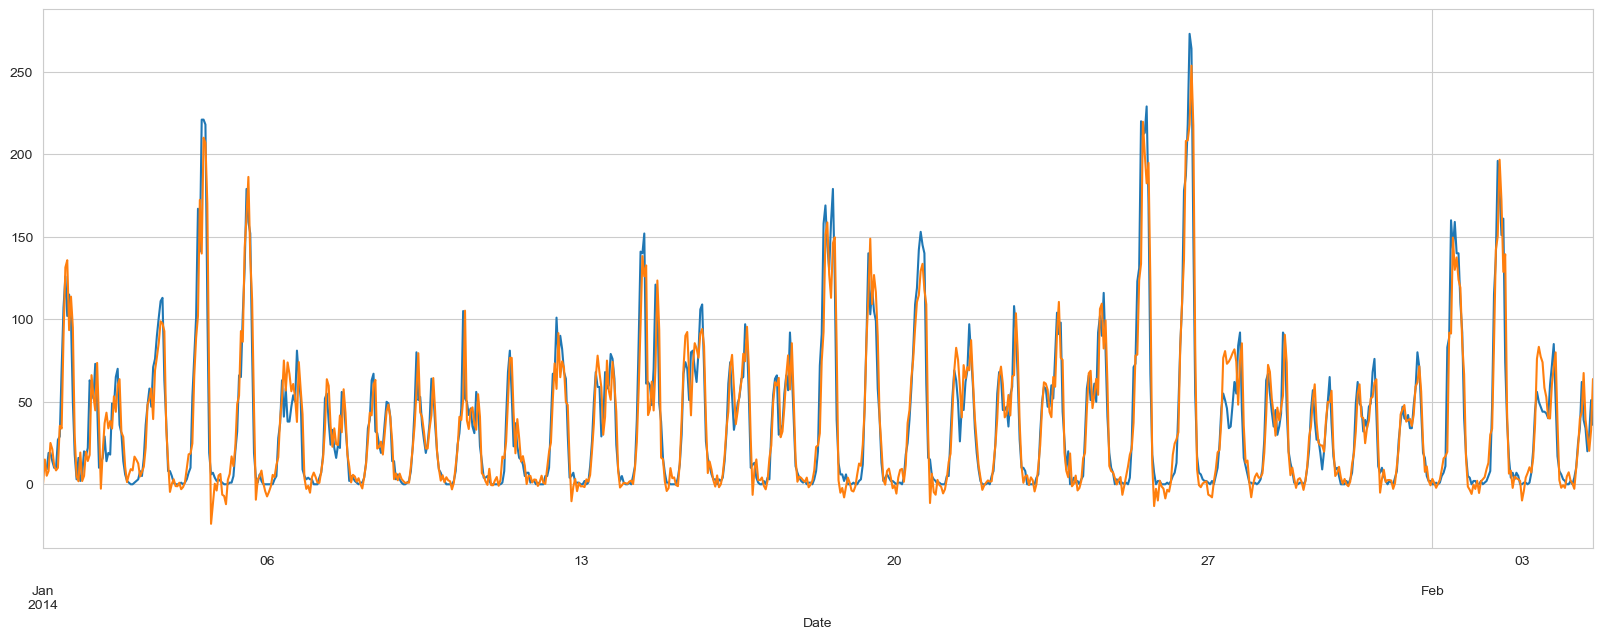

In [74]:
#обучим модель
train_pred, train_err = model1.train(train, train_config={"enforce_stationarity": True,
                                                          "enforce_invertibility": True})
#визуализируем предсказания на обучающей выборке
train.univariates["BGT North of NE 70th Total"].plot(figsize=(20,7))
train_pred.univariates["BGT North of NE 70th Total"].plot(figsize=(20,7))

Arima MAE is 9.617


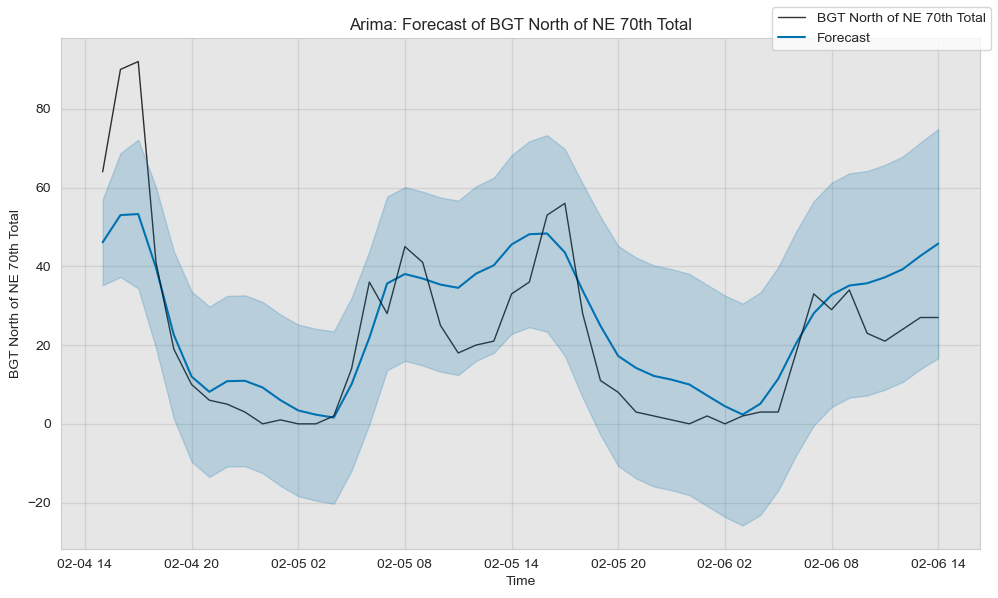

In [75]:
#получим отметки времени из тестовой выборки
time_stamps = test.time_stamps
#построим прогноз
forecast1, stderr1 = model1.forecast(time_stamps=time_stamps[:forecast_steps])
#рассчитаем метрику MAE
smape1 = ForecastMetric.MAE.value(ground_truth=test[:forecast_steps], predict=forecast1)
print(f"{type(model1).__name__} MAE is {smape1:.3f}")
#визуализируем предсказние на тестовой выборке
fig, ax = model1.plot_forecast(time_series=test[:forecast_steps], plot_forecast_uncertainty=True)
plt.show()

In [6]:
from merlion.models.forecast.transformer import TransformerConfig, TransformerForecaster

modelConfig = TransformerConfig(ts_encoding="h", max_forecast_steps=48, n_past=48,
                                normalize = MinMaxNormalize())
model2 = TransformerForecaster(modelConfig)

GPU not available, using CPU instead


 |========================================| 100.0% Train Loss:  0.0224, Validation Loss:  0.0142


<AxesSubplot:xlabel='Date'>

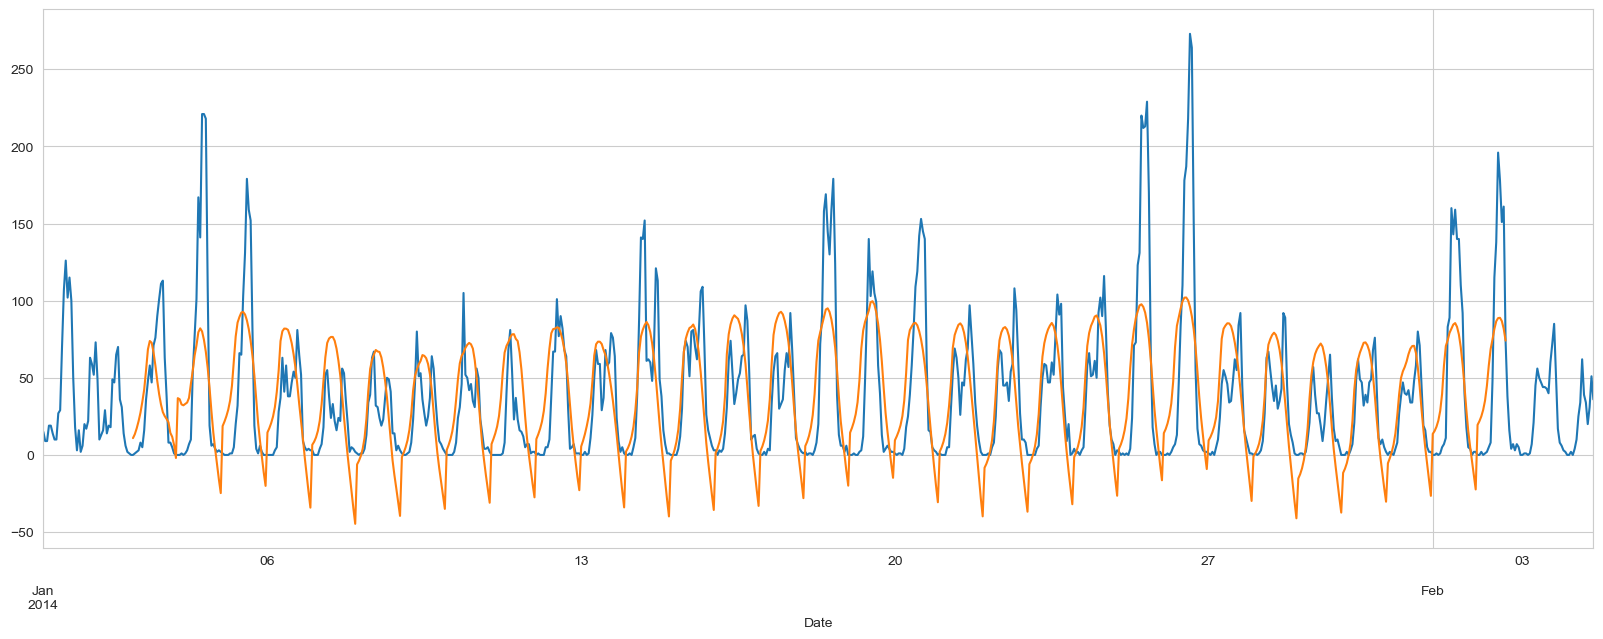

In [8]:
train_pred, stderr2 = model2.train(train)
#визуализируем предсказания на обучающей выборке
train.univariates["BGT North of NE 70th Total"].plot(figsize=(20,7))
train_pred.univariates["BGT North of NE 70th Total"].plot(figsize=(20,7))

Model returned err = None, so returning IQR = (None, None)


TransformerForecaster MAE is 15.187


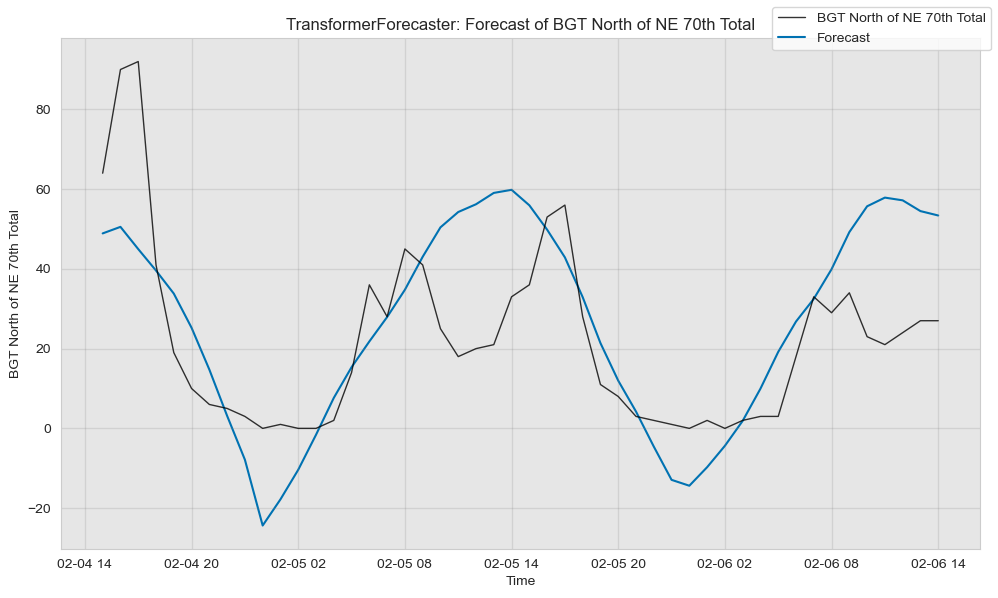

In [10]:
#получим отметки времени из тестовой выборки
time_stamps = test.time_stamps
#построим прогноз
forecast2, stderr2 = model2.forecast(time_stamps=time_stamps[:48])
#рассчитаем метрику MAE
smape1 = ForecastMetric.MAE.value(ground_truth=test[:48], predict=forecast2)
print(f"{type(model2).__name__} MAE is {smape1:.3f}")
#визуализируем предсказние на тестовой выборке
fig, ax = model2.plot_forecast(time_series=test[:48], plot_forecast_uncertainty=True)
plt.show()

In [79]:
from merlion.models.forecast.trees import LGBMForecasterConfig
from merlion.models.forecast.trees import LGBMForecaster

modelConfig = LGBMForecasterConfig(ts_encoding="h", max_forecast_steps=48, n_past=48, n_estimators=150)
model2 = LGBMForecaster(modelConfig)

In [ ]:
model2.train_pre_process()

Inferred granularity <Hour>


<AxesSubplot:xlabel='Date'>

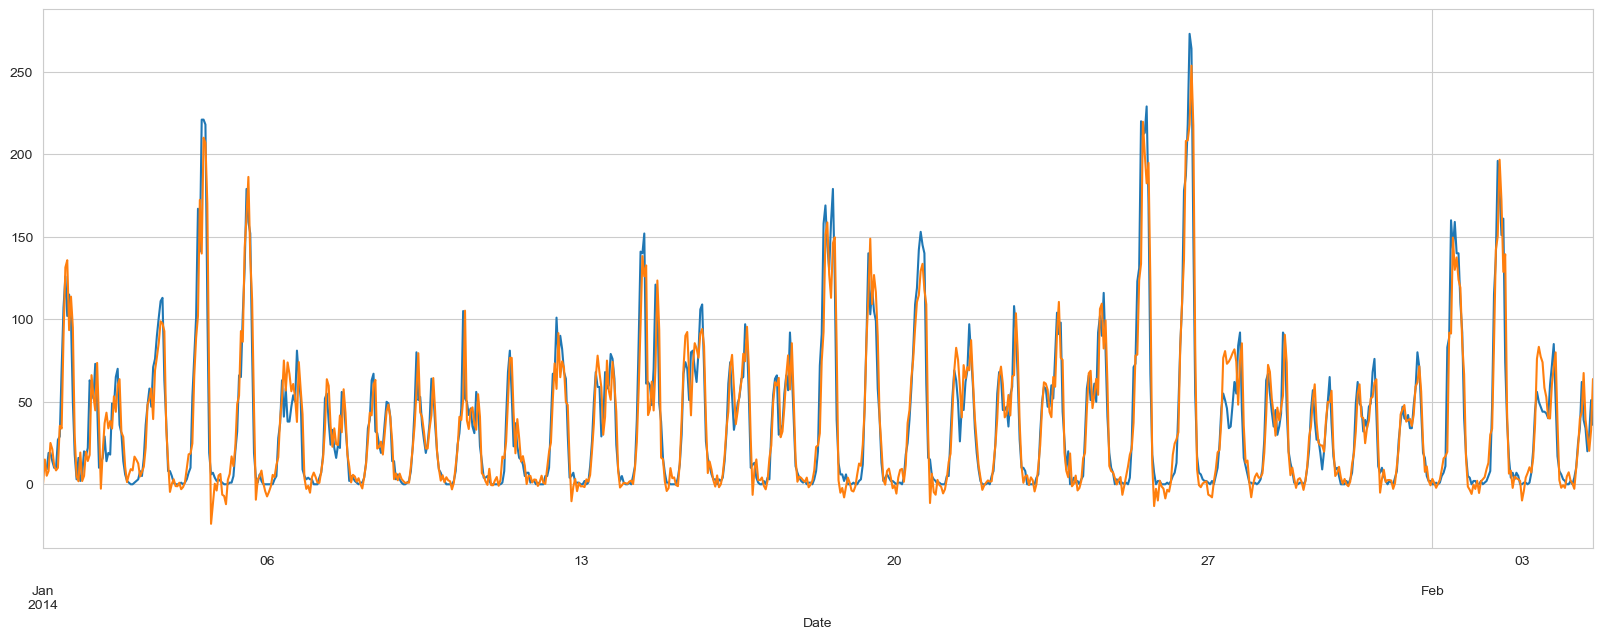

In [80]:
forecast2, stderr2 = model2.train(train)
#визуализируем предсказания на обучающей выборке
train.univariates["BGT North of NE 70th Total"].plot(figsize=(20,7))
train_pred.univariates["BGT North of NE 70th Total"].plot(figsize=(20,7))

Model returned err = None, so returning IQR = (None, None)


LGBMForecaster MAE is 10.501


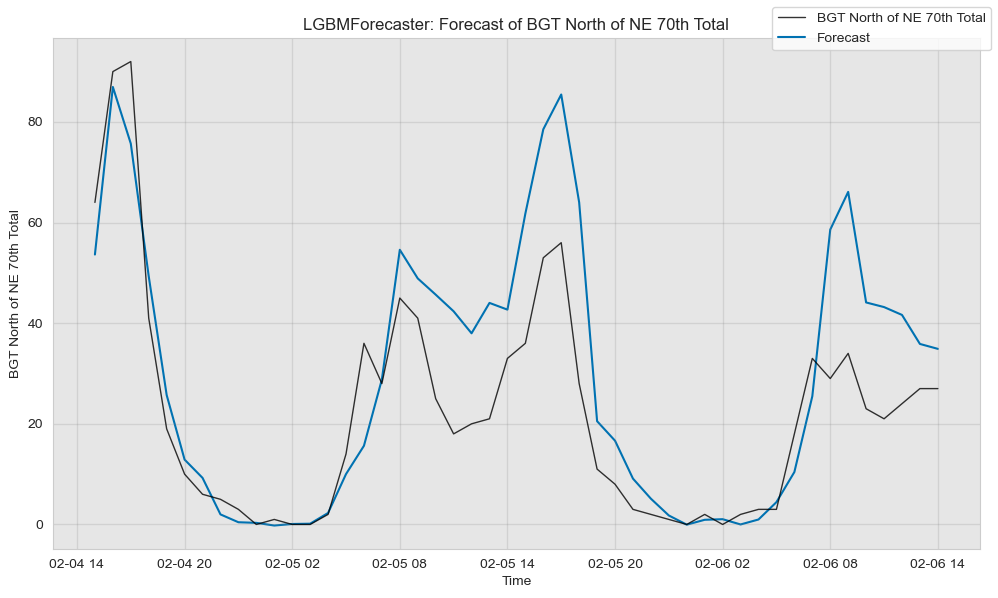

In [81]:
#получим отметки времени из тестовой выборки
time_stamps = test.time_stamps
#построим прогноз
forecast2, stderr2 = model2.forecast(time_stamps=time_stamps[:forecast_steps])
#рассчитаем метрику MAE
smape2 = ForecastMetric.MAE.value(ground_truth=test, predict=forecast2)
print(f"{type(model2).__name__} MAE is {smape2:.3f}")
#визуализируем предсказние на тестовой выборке
fig, ax = model2.plot_forecast(time_series=test[:forecast_steps], plot_forecast_uncertainty=True)
plt.show()

In [82]:
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.ensemble.combine import Mean, Median, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig

ensemble_config = ForecasterEnsembleConfig(
    combiner=Median(), models=[model1, model2])
ensemble = ForecasterEnsemble(config=ensemble_config)


selector_config = ForecasterEnsembleConfig(
    combiner=ModelSelector(metric=ForecastMetric.MAE))
selector = ForecasterEnsemble(
    config=selector_config, models=[model1, model2])

Inferred granularity <Hour>
Inferred granularity <Hour>


<AxesSubplot:xlabel='Date'>

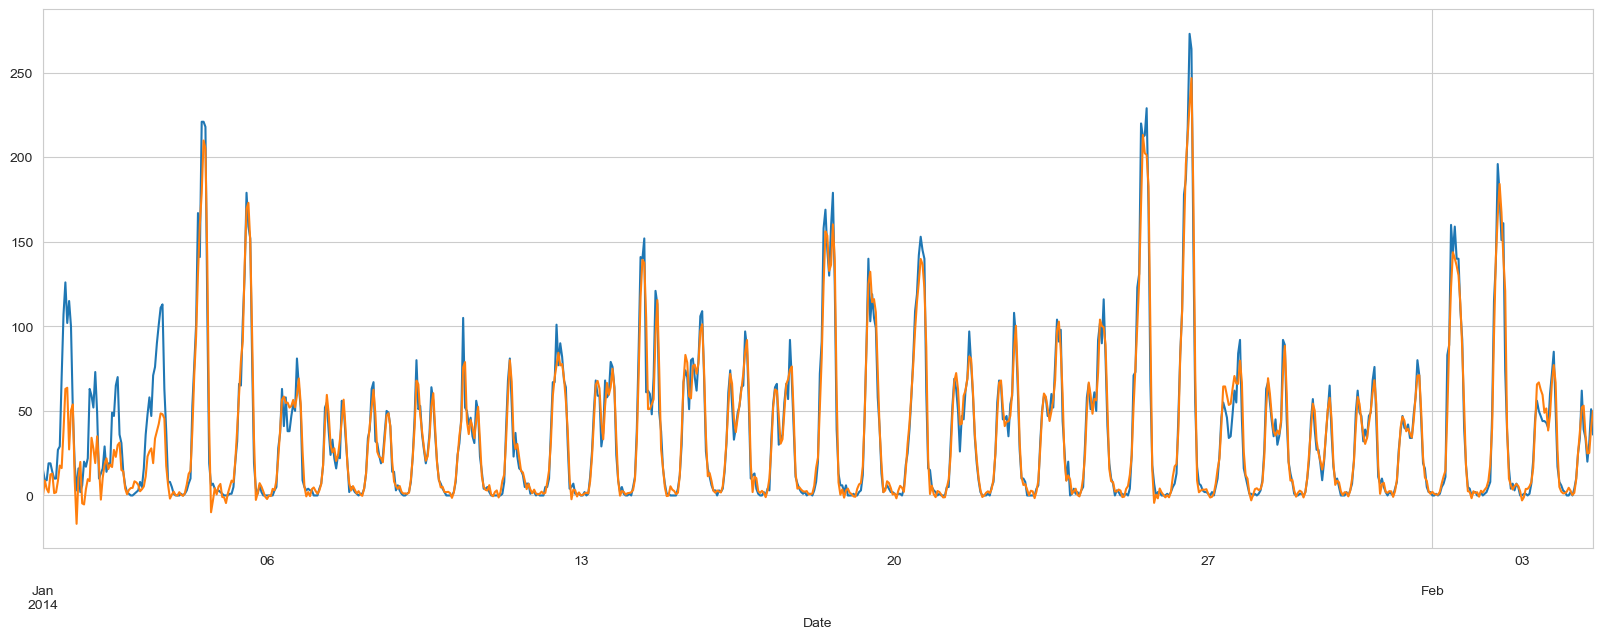

In [83]:
forecast_sel, stderr_sel = ensemble.train(train)
#визуализируем предсказания на обучающей выборке
train.univariates["BGT North of NE 70th Total"].plot(figsize=(20,7))
forecast_sel.univariates["BGT North of NE 70th Total"].plot(figsize=(20,7))

Model returned err = None, so returning IQR = (None, None)


ForecasterEnsemble MAE is 9.105


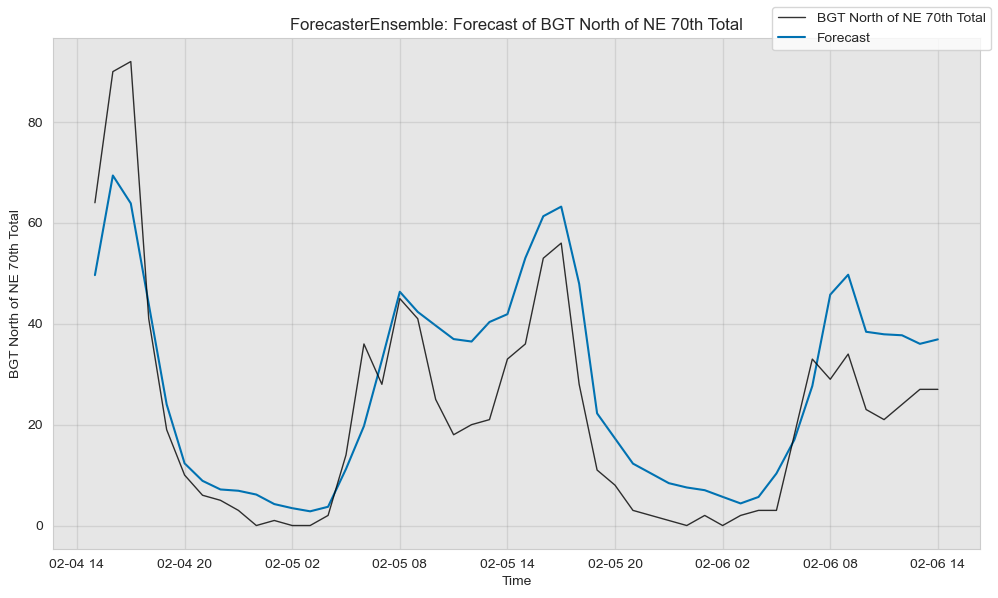

In [85]:
#получим отметки времени из тестовой выборки
time_stamps = test.time_stamps
#построим прогноз
forecast_sel, stderr_sel = ensemble.forecast(time_stamps=time_stamps[:forecast_steps])
#рассчитаем метрику MAE
smape1 = ForecastMetric.MAE.value(ground_truth=test[:forecast_steps], predict=forecast_sel)
print(f"{type(ensemble).__name__} MAE is {smape1:.3f}")
#визуализируем предсказние на тестовой выборке
fig, ax = ensemble.plot_forecast(time_series=test[:forecast_steps], plot_forecast_uncertainty=True)
plt.show()

In [88]:
from merlion.evaluate.forecast import ForecastEvaluator, ForecastEvaluatorConfig, ForecastMetric

def create_evaluator(model):
    model.reset()
    evaluator = ForecastEvaluator(
        model=model, config=ForecastEvaluatorConfig(
            horizon="48h", retrain_freq="24h")
    )
    return evaluator

ensemble_evaluator = create_evaluator(model1)
ensemble_train_result, ensemble_test_result = ensemble_evaluator.get_predict(train_vals=train,
                                                                 test_vals=test[:240])

Inferred granularity <Hour>
ForecastEvaluator: 100%|██████████| 604800/604800 [00:22<00:00, 27475.46it/s]


In [89]:
mae = ensemble_evaluator.evaluate(
    ground_truth=test[:240],
    predict=ensemble_test_result,
    metric=ForecastMetric.MAE)
print(f"{type(ensemble).__name__} MAE:  {mae:.3f}")

ForecasterEnsemble MAE:  16.197
